In [175]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import timm

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from pyts.image import GramianAngularField, MarkovTransitionField
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

## Vision Transformer Function

In [176]:
# Create NumpyDataset class for using with ViT
class NumpyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data[:, :, :, :3].astype(np.float32) # Select only RGB channel
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [177]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor() # Swap from (Height, Width, Channel) to (Channel, Width, Height)
])

In [178]:
def evaluate(model, dataloader, device):
    model.eval() 
    all_predictions = []

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1) # Get class with the highest probability
            all_predictions.extend(predicted.cpu().numpy())

    return np.array(all_predictions)

In [179]:
X_train_normalized = np.load('E:/thesis project/thesis_proj/X_train_normalized.npy')
X_test_normalized = np.load('E:/thesis project/thesis_proj/X_test_normalized.npy')
X_train_normalized = np.load('E:/thesis project/thesis_proj/X_train_normalized.npy')
X_train_normalized_aug = np.load('E:/thesis project/thesis_proj/X_train_normalized_aug.npy')
y1_test = np.load('E:/thesis project/thesis_proj/y1_test.npy')
y1_train = np.load('E:/thesis project/thesis_proj/y1_train.npy')
y_train_int_aug = np.load('E:/thesis project/thesis_proj/y_train_int_aug.npy')
# For model
EPOCH = 30
BATCHSIZE = 32
VAL = 0.2
BASE = 'E:/thesis project/thesis_proj/'
PLOTSIZE = 224 # Size of GAF and MTF image
IMAGESIZE = 224 # Size of image loaded from buffer

In [180]:
benign = ['AESCrypt', 'Zip', 'SDelete', 'Excel', 'Firefox']
ransomware = ['TeslaCrypt', 'Cerber', 'WannaCry', 'GandCrab4', 'Ryuk', 'Sodinokibi', 'Darkside']

## Label Encoder

In [181]:
benign = ['AESCrypt', 'Zip', 'SDelete', 'Excel', 'Firefox']
ransomware = ['TeslaCrypt', 'Cerber', 'WannaCry', 'GandCrab4', 'Ryuk', 'Sodinokibi', 'Darkside']

In [182]:
y_train = []

for y in y1_train:
    if y in benign:
        y_train.append('Benign')
    else:
        y_train.append('Ransomware')

In [183]:
y_test = []

for y in y1_test:
    if y in benign:
        y_test.append('Benign')
    else:
        y_test.append('Ransomware')

In [184]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [185]:
lbl = LabelEncoder()

In [186]:
classes, count = np.unique(y_train, return_counts=True)
print(classes)
print(count)

['Benign' 'Ransomware']
[160 672]


In [187]:
print(lbl.fit_transform(classes), classes)
y_train_int = lbl.fit_transform(y_train)
y_train_int.shape

[0 1] ['Benign' 'Ransomware']


(832,)

In [188]:
classes_test, count_test = np.unique(y_test, return_counts=True)
print(classes_test)
print(count_test)

['Benign' 'Ransomware']
[ 41 171]


In [189]:
y_test_int = lbl.transform(y_test)
y_test_int.shape

(212,)

In [190]:
SEED = 42

In [191]:
NUMCLASS = len(classes)

# Image as an Input

In [192]:
PLOTSIZE = 16 # Size of GAF and MTF image
IMAGESIZE = 64 # Size of image loaded from buffer

In [193]:
data_train_transposed = np.transpose(X_train_normalized, (0, 2, 1))
data_train_transposed.shape

(832, 5, 16)

In [194]:
data_train_aug_transposed = np.transpose(X_train_normalized_aug, (0, 2, 1))
data_train_aug_transposed.shape

(1344, 5, 16)

In [195]:
data_test_transposed = np.transpose(X_test_normalized, (0, 2, 1))
data_test_transposed.shape

(212, 5, 16)

## Gramian Angular Field

In [196]:
gaf0 = GramianAngularField(image_size=PLOTSIZE)
gaf1 = GramianAngularField(image_size=PLOTSIZE)
gaf2 = GramianAngularField(image_size=PLOTSIZE)
gaf3 = GramianAngularField(image_size=PLOTSIZE)
gaf4 = GramianAngularField(image_size=PLOTSIZE)
print(PLOTSIZE)


16


In [197]:
gaf_train_f0 = gaf0.fit_transform(data_train_transposed[:, 0, :])
gaf_train_f1 = gaf1.fit_transform(data_train_transposed[:, 1, :])
gaf_train_f2 = gaf2.fit_transform(data_train_transposed[:, 2, :])
gaf_train_f3 = gaf3.fit_transform(data_train_transposed[:, 3, :])
gaf_train_f4 = gaf4.fit_transform(data_train_transposed[:, 4, :])
#print(gaf_train_f1.shape)

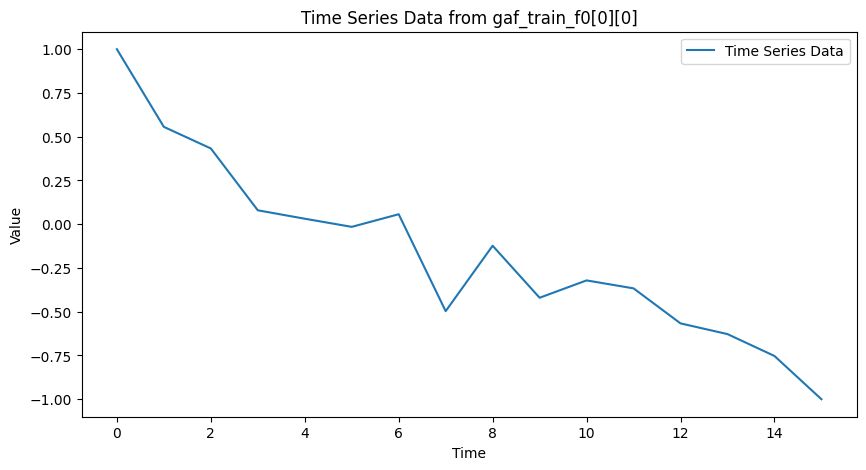

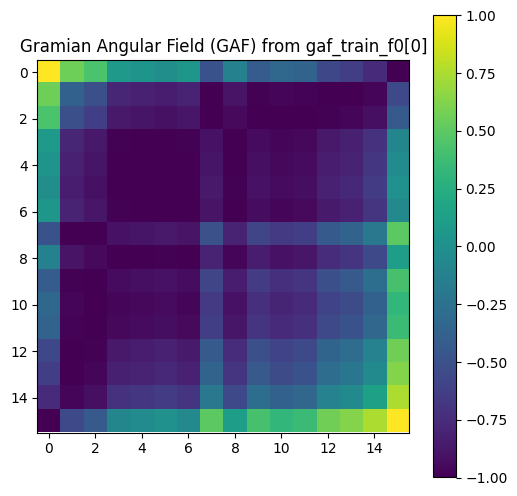

In [198]:
gaf_train = np.empty((data_train_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_train_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            # Average all values in the same position
            gaf_train[i][j][k] = (gaf_train_f0[i][j][k] + gaf_train_f1[i][j][k] + gaf_train_f2[i][j][k] + gaf_train_f3[i][j][k] + gaf_train_f4[i][j][k])/5

#plt.imshow(gaf_train[0, :, :])
time_series_data = gaf_train_f0[0][0]

# Plot the time series data as a line graph
plt.figure(figsize=(10, 5))
plt.plot(time_series_data, label='Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data from gaf_train_f0[0][0]')
plt.legend()
plt.show()

# Plot the GAF using gaf_train_f0[0]
plt.figure(figsize=(6, 6))
plt.imshow(gaf_train_f0[0])
plt.colorbar()
plt.title('Gramian Angular Field (GAF) from gaf_train_f0[0]')
plt.show()

In [199]:
gaf_img_train_tmp = []

for i,g in enumerate(gaf_train):
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    gaf_img_train_tmp.append(image_array)

     # Save the image to the specified directory
    image.save(os.path.join("E:/thesis project/thesis_proj/image_train", f"gaf_image_{i}.png"))

In [200]:
gaf_img_train = np.stack(gaf_img_train_tmp, axis=0)
gaf_img_train = gaf_img_train/255
gaf_img_train.shape
#print(gaf_img_train[0])

(832, 64, 64, 4)

In [201]:
gaf_test_f0 = gaf0.transform(data_test_transposed[:, 0, :])
gaf_test_f1 = gaf1.transform(data_test_transposed[:, 1, :])
gaf_test_f2 = gaf2.transform(data_test_transposed[:, 2, :])
gaf_test_f3 = gaf3.transform(data_test_transposed[:, 3, :])
gaf_test_f4 = gaf4.transform(data_test_transposed[:, 4, :])

In [202]:
gaf_test = np.empty((data_test_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_test_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            gaf_test[i][j][k] = (gaf_test_f0[i][j][k] + gaf_test_f1[i][j][k] + gaf_test_f2[i][j][k] + gaf_test_f3[i][j][k] + gaf_test_f4[i][j][k])/5

In [203]:
gaf_img_test_tmp = []

for i,g in enumerate(gaf_test):
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    gaf_img_test_tmp.append(image_array)

    # Save the image to the specified directory
    image.save(os.path.join("E:/thesis project/thesis_proj/image_test", f"gaf_image_{i}.png"))

In [204]:
gaf_img_test = np.stack(gaf_img_test_tmp, axis=0)
gaf_img_test = gaf_img_test/255
gaf_img_test.shape

(212, 64, 64, 4)

### CNN

In [205]:
SEED = 42
tf.random.set_seed(SEED)
cnn_gaf = Sequential(name='CNN_GAF')
cnn_gaf.add(Conv2D(32, (3, 3), activation='relu', input_shape=(gaf_img_train.shape[1], gaf_img_train.shape[2], gaf_img_train.shape[3])))
cnn_gaf.add(MaxPooling2D((2, 2)))
cnn_gaf.add(Dropout(0.2))
cnn_gaf.add(Conv2D(16, (3, 3), activation='relu'))
cnn_gaf.add(MaxPooling2D((2, 2)))
cnn_gaf.add(Dropout(0.2))
cnn_gaf.add(Conv2D(8, (3, 3), activation='relu'))
cnn_gaf.add(MaxPooling2D((2, 2)))
cnn_gaf.add(Flatten())
cnn_gaf.add(Dense(8, activation='relu'))
cnn_gaf.add(Dense(NUMCLASS, activation='softmax'))

cnn_gaf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [206]:
cnn_gaf.summary()

Model: "CNN_GAF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,298 (36.32 KB)

 Trainable params: 9,298 (36.32 KB)

 Non-trainable params: 0 (0.00 B)

In [207]:
tf.random.set_seed(SEED)
cnn_gaf_history = cnn_gaf.fit(gaf_img_train, to_categorical(y_train_int), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6146 - loss: 0.6368 - val_accuracy: 0.8084 - val_loss: 0.4947
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5118 - val_accuracy: 0.8084 - val_loss: 0.5005
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5145 - val_accuracy: 0.8084 - val_loss: 0.5170
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5083 - val_accuracy: 0.8084 - val_loss: 0.5089
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5011 - val_accuracy: 0.8084 - val_loss: 0.5053
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5041 - val_accuracy: 0.8084 - val_loss: 0.5042
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5026 - val_accuracy: 0.8084 - val_loss: 0.5021
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7985 - loss: 0.5020 - val_accuracy: 0.8084 - va

<function matplotlib.pyplot.show(close=None, block=None)>

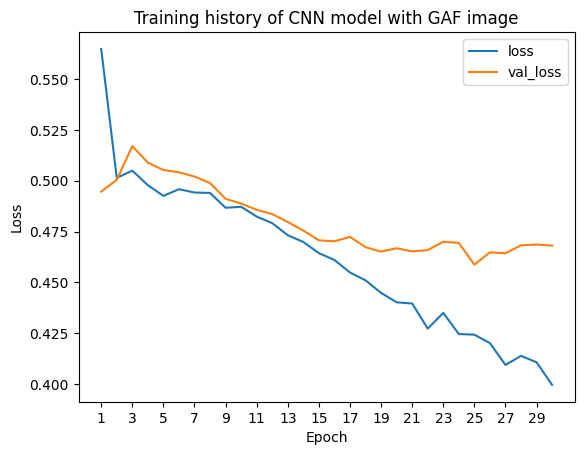

In [208]:
plt.plot(cnn_gaf_history.history['loss'], label='loss')
plt.plot(cnn_gaf_history.history['val_loss'], label='val_loss')
plt.xticks(range(0, EPOCH, 2), range(1, EPOCH+1, 2))
plt.title('Training history of CNN model with GAF image')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [209]:
cnn_gaf.save(f'{BASE}/Models/cnn_gaf.h5')

### ViT

In [210]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
gaf_train_dataloader = DataLoader(NumpyDataset(gaf_img_train, y_train_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
gaf_test_dataloader = DataLoader(NumpyDataset(gaf_img_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [211]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_gaf = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_gaf.head = nn.Linear(vit_gaf.head.in_features, NUMCLASS)
vit_gaf = vit_gaf.to(device)

In [212]:
# Freeze all layer except added head layer
for param in vit_gaf.parameters():
    param.requires_grad = False
for param in vit_gaf.head.parameters():
    param.requires_grad = True

In [213]:
# Count parameters
total_params = sum(p.numel() for p in vit_gaf.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_gaf.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [214]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_gaf.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_gaf.train()
    running_loss = 0

    for inputs, labels in gaf_train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_gaf(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(gaf_train_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.5715
Epoch 2/30, Loss: 0.4414
Epoch 3/30, Loss: 0.4204
Epoch 4/30, Loss: 0.4119
Epoch 5/30, Loss: 0.4052
Epoch 6/30, Loss: 0.3995
Epoch 7/30, Loss: 0.3943
Epoch 8/30, Loss: 0.3895
Epoch 9/30, Loss: 0.3852
Epoch 10/30, Loss: 0.3811
Epoch 11/30, Loss: 0.3773
Epoch 12/30, Loss: 0.3738
Epoch 13/30, Loss: 0.3704
Epoch 14/30, Loss: 0.3673
Epoch 15/30, Loss: 0.3643
Epoch 16/30, Loss: 0.3614
Epoch 17/30, Loss: 0.3587
Epoch 18/30, Loss: 0.3560
Epoch 19/30, Loss: 0.3535
Epoch 20/30, Loss: 0.3511
Epoch 21/30, Loss: 0.3488
Epoch 22/30, Loss: 0.3465
Epoch 23/30, Loss: 0.3443
Epoch 24/30, Loss: 0.3422
Epoch 25/30, Loss: 0.3402
Epoch 26/30, Loss: 0.3382
Epoch 27/30, Loss: 0.3363
Epoch 28/30, Loss: 0.3345
Epoch 29/30, Loss: 0.3327
Epoch 30/30, Loss: 0.3309


In [215]:
torch.save(vit_gaf.state_dict(), f'{BASE}/Models/vit_gaf.pth')

### Evaluation

#### CNN

In [216]:
tf.random.set_seed(SEED)
cnn_gaf_pred = cnn_gaf.predict(gaf_img_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [217]:
cnn_gaf_pred_int = np.argmax(cnn_gaf_pred, axis=1)

In [218]:
print('Accuracy:', accuracy_score(y_test_int, cnn_gaf_pred_int))
print('Precision:', precision_score(y_test_int, cnn_gaf_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_gaf_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_gaf_pred_int, average='macro'))

Accuracy: 0.8066037735849056
Precision: 0.4033018867924528
Recall: 0.5
F1-Score: 0.4464751958224543


C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


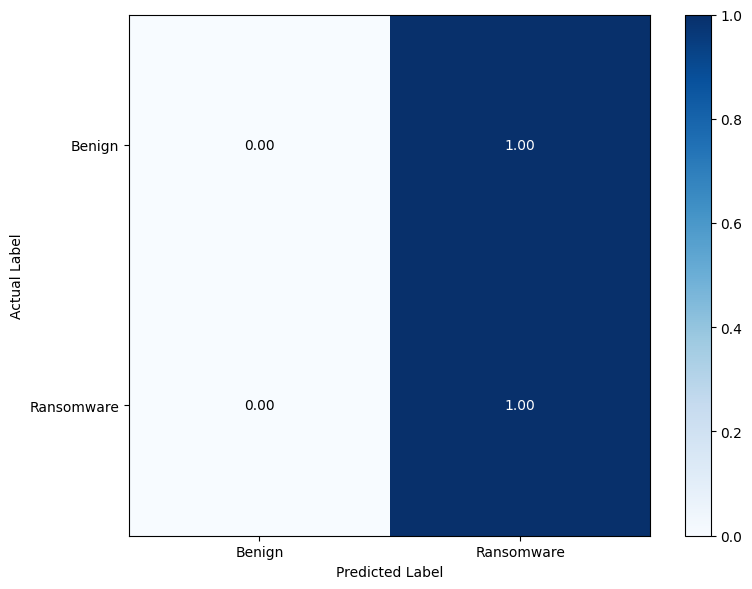

In [219]:
confusionMatrix_cnn_gaf = confusion_matrix(y_test_int, cnn_gaf_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_gaf, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_gaf.shape[0]):
    for j in range(confusionMatrix_cnn_gaf.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_gaf[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_gaf[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

#### ViT

In [220]:
vit_gaf_pred_int = evaluate(vit_gaf, gaf_test_dataloader, device)

In [221]:
print('Accuracy:', accuracy_score(y_test_int, vit_gaf_pred_int))
print('Precision:', precision_score(y_test_int, vit_gaf_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_gaf_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_gaf_pred_int, average='macro'))

Accuracy: 0.8443396226415094
Precision: 0.7562271062271062
Recall: 0.6995435743831122
F1-Score: 0.7208634241710888


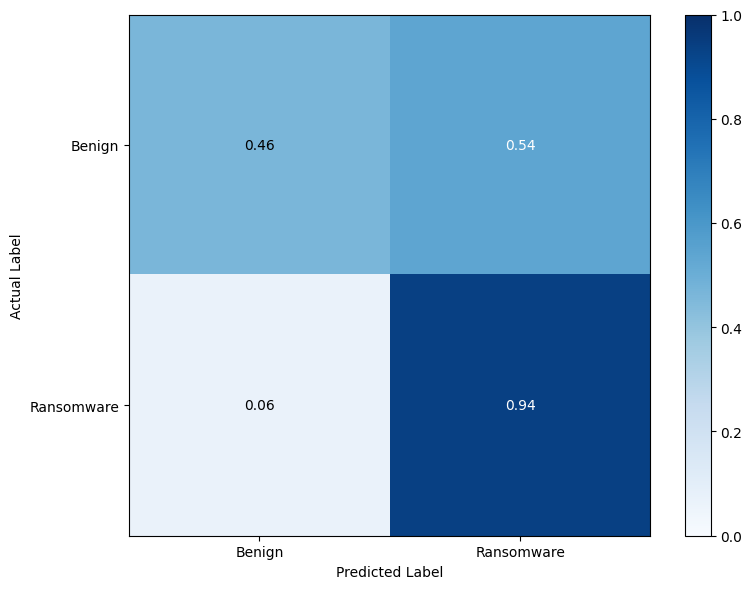

In [222]:
confusionMatrix_vit_gaf = confusion_matrix(y_test_int, vit_gaf_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_gaf, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_gaf.shape[0]):
    for j in range(confusionMatrix_vit_gaf.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_gaf[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_gaf[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

### GAF Augmentation

In [223]:
gaf0_aug = GramianAngularField(image_size=PLOTSIZE)
gaf1_aug = GramianAngularField(image_size=PLOTSIZE)
gaf2_aug = GramianAngularField(image_size=PLOTSIZE)
gaf3_aug = GramianAngularField(image_size=PLOTSIZE)
gaf4_aug = GramianAngularField(image_size=PLOTSIZE)

In [224]:
gaf_train_aug_f0 = gaf0_aug.fit_transform(data_train_aug_transposed[:, 0, :])
gaf_train_aug_f1 = gaf1_aug.fit_transform(data_train_aug_transposed[:, 1, :])
gaf_train_aug_f2 = gaf2_aug.fit_transform(data_train_aug_transposed[:, 2, :])
gaf_train_aug_f3 = gaf3_aug.fit_transform(data_train_aug_transposed[:, 3, :])
gaf_train_aug_f4 = gaf4_aug.fit_transform(data_train_aug_transposed[:, 4, :])

In [225]:
gaf_train_aug = np.empty((data_train_aug_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_train_aug_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            gaf_train_aug[i][j][k] = (gaf_train_aug_f0[i][j][k] + gaf_train_aug_f1[i][j][k] + gaf_train_aug_f2[i][j][k] + gaf_train_aug_f3[i][j][k] + gaf_train_aug_f4[i][j][k])/5

In [226]:
gaf_img_train_aug_tmp = []

for g in gaf_train_aug:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    gaf_img_train_aug_tmp.append(image_array)

In [227]:
gaf_img_train_aug = np.stack(gaf_img_train_aug_tmp, axis=0)
gaf_img_train_aug = gaf_img_train_aug/255
gaf_img_train_aug.shape

(1344, 64, 64, 4)

In [228]:
gaf_test_f0 = gaf0_aug.transform(data_test_transposed[:, 0, :])
gaf_test_f1 = gaf1_aug.transform(data_test_transposed[:, 1, :])
gaf_test_f2 = gaf2_aug.transform(data_test_transposed[:, 2, :])
gaf_test_f3 = gaf3_aug.transform(data_test_transposed[:, 3, :])
gaf_test_f4 = gaf4_aug.transform(data_test_transposed[:, 4, :])

In [229]:
gaf_test = np.empty((data_test_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_test_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            gaf_test[i][j][k] = (gaf_test_f0[i][j][k] + gaf_test_f1[i][j][k] + gaf_test_f2[i][j][k] + gaf_test_f3[i][j][k] + gaf_test_f4[i][j][k])/5

In [230]:
gaf_img_test_tmp = []

for g in gaf_test:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    gaf_img_test_tmp.append(image_array)

In [231]:
gaf_img_test = np.stack(gaf_img_test_tmp, axis=0)
gaf_img_test = gaf_img_test/255
gaf_img_test.shape

(212, 64, 64, 4)

#### CNN with SMOTE

In [232]:
tf.random.set_seed(SEED)
cnn_gaf_aug = Sequential(name='CNN_GAF_aug')
cnn_gaf_aug.add(Conv2D(32, (3, 3), activation='relu', input_shape=(gaf_img_train_aug.shape[1], gaf_img_train_aug.shape[2], gaf_img_train_aug.shape[3])))
cnn_gaf_aug.add(MaxPooling2D((2, 2)))
cnn_gaf_aug.add(Dropout(0.2))
cnn_gaf_aug.add(Conv2D(16, (3, 3), activation='relu'))
cnn_gaf_aug.add(MaxPooling2D((2, 2)))
cnn_gaf_aug.add(Dropout(0.2))
cnn_gaf_aug.add(Conv2D(8, (3, 3), activation='relu'))
cnn_gaf_aug.add(MaxPooling2D((2, 2)))
cnn_gaf_aug.add(Flatten())
cnn_gaf_aug.add(Dense(8, activation='relu'))
cnn_gaf_aug.add(Dense(NUMCLASS, activation='softmax'))

cnn_gaf_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [233]:
cnn_gaf_aug.summary()

Model: "CNN_GAF_aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 29, 29, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,298 (36.32 KB)

 Trainable params: 9,298 (36.32 KB)

 Non-trainable params: 0 (0.00 B)

In [234]:
tf.random.set_seed(SEED)
cnn_gaf_aug_history = cnn_gaf_aug.fit(gaf_img_train_aug, to_categorical(y_train_int_aug), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5724 - loss: 0.6808 - val_accuracy: 0.0000e+00 - val_loss: 0.8196
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6144 - loss: 0.6636 - val_accuracy: 0.0000e+00 - val_loss: 0.8307
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6144 - loss: 0.6594 - val_accuracy: 0.0112 - val_loss: 0.8203
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6237 - loss: 0.6367 - val_accuracy: 0.2900 - val_loss: 0.7810
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6572 - loss: 0.6192 - val_accuracy: 0.5948 - val_loss: 0.6719
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6740 - loss: 0.6018 - val_accuracy: 0.6357 - val_loss: 0.6649
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6933 - loss: 0.5848 - val_accuracy: 0.6803 - val_loss: 0.6295
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7008 - loss: 0.5740 - val_accuracy: 0.639

<function matplotlib.pyplot.show(close=None, block=None)>

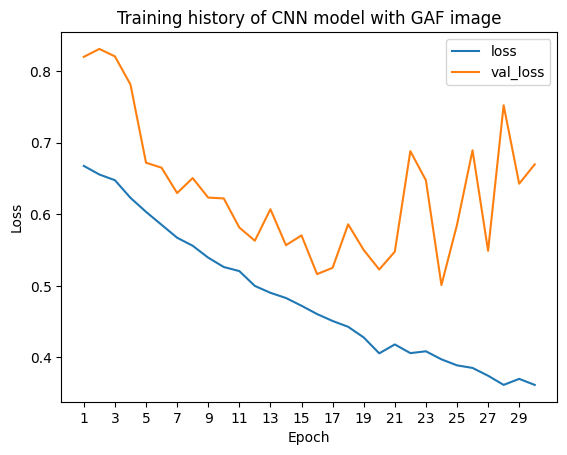

In [235]:
plt.plot(cnn_gaf_aug_history.history['loss'], label='loss')
plt.plot(cnn_gaf_aug_history.history['val_loss'], label='val_loss')
plt.xticks(range(0, EPOCH, 2), range(1, EPOCH+1, 2))
plt.title('Training history of CNN model with GAF image')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [236]:
cnn_gaf_aug.save(f'{BASE}/Models/cnn_gaf_aug.h5')

#### ViT with SMOTE

In [237]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
gaf_train_aug_dataloader = DataLoader(NumpyDataset(gaf_img_train_aug, y_train_int_aug, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
gaf_test_dataloader = DataLoader(NumpyDataset(gaf_img_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [238]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_gaf_aug = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_gaf_aug.head = nn.Linear(vit_gaf_aug.head.in_features, NUMCLASS)
vit_gaf_aug = vit_gaf_aug.to(device)

In [239]:
for param in vit_gaf_aug.parameters():
    param.requires_grad = False
for param in vit_gaf_aug.head.parameters():
    param.requires_grad = True

In [240]:
total_params = sum(p.numel() for p in vit_gaf_aug.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_gaf_aug.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [241]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_gaf_aug.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_gaf_aug.train()
    running_loss = 0

    for inputs, labels in gaf_train_aug_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_gaf_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(gaf_train_aug_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.4781
Epoch 2/30, Loss: 2.3262
Epoch 3/30, Loss: 3.0944
Epoch 4/30, Loss: 2.5613
Epoch 5/30, Loss: 2.2008
Epoch 6/30, Loss: 2.0632
Epoch 7/30, Loss: 2.0076
Epoch 8/30, Loss: 1.9724
Epoch 9/30, Loss: 1.9431
Epoch 10/30, Loss: 1.9162
Epoch 11/30, Loss: 1.8910
Epoch 12/30, Loss: 1.8670
Epoch 13/30, Loss: 1.8442
Epoch 14/30, Loss: 1.8225
Epoch 15/30, Loss: 1.8018
Epoch 16/30, Loss: 1.7821
Epoch 17/30, Loss: 1.7633
Epoch 18/30, Loss: 1.7454
Epoch 19/30, Loss: 1.7284
Epoch 20/30, Loss: 1.7122
Epoch 21/30, Loss: 1.6969
Epoch 22/30, Loss: 1.6824
Epoch 23/30, Loss: 1.6685
Epoch 24/30, Loss: 1.6554
Epoch 25/30, Loss: 1.6430
Epoch 26/30, Loss: 1.6312
Epoch 27/30, Loss: 1.6200
Epoch 28/30, Loss: 1.6094
Epoch 29/30, Loss: 1.5993
Epoch 30/30, Loss: 1.5897


In [242]:
torch.save(vit_gaf_aug.state_dict(), f'{BASE}/Models/vit_gaf_aug.pth')

#### Evaluation

##### CNN

In [243]:
tf.random.set_seed(SEED)
cnn_gaf_aug_pred = cnn_gaf_aug.predict(gaf_img_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [244]:
cnn_gaf_aug_pred_int = np.argmax(cnn_gaf_aug_pred, axis=1)

In [245]:
print('Accuracy:', accuracy_score(y_test_int, cnn_gaf_aug_pred_int))
print('Precision:', precision_score(y_test_int, cnn_gaf_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_gaf_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_gaf_aug_pred_int, average='macro'))

Accuracy: 0.8349056603773585
Precision: 0.734875983061101
Recall: 0.7215090571958351
F1-Score: 0.7277563749770684


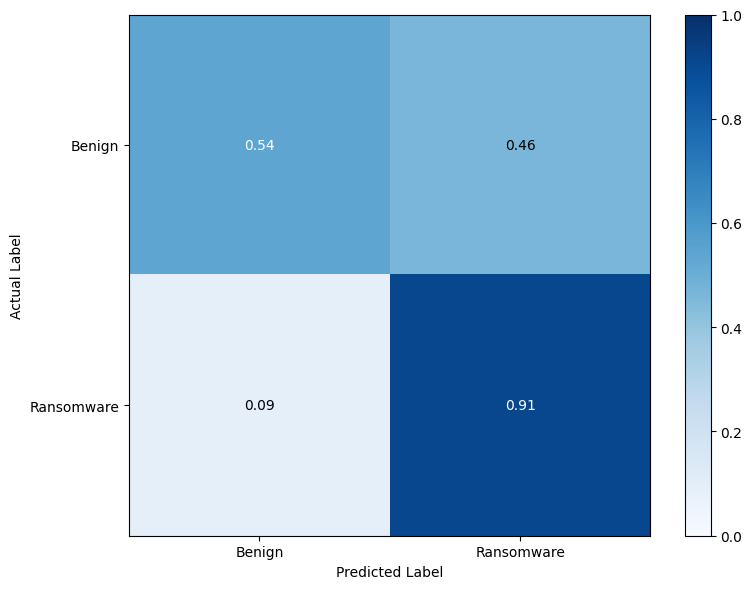

In [246]:
confusionMatrix_cnn_gaf_aug = confusion_matrix(y_test_int, cnn_gaf_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_gaf_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_gaf_aug.shape[0]):
    for j in range(confusionMatrix_cnn_gaf_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_gaf_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_gaf_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

##### ViT

In [247]:
vit_gaf_aug_pred_int = evaluate(vit_gaf_aug, gaf_test_dataloader, device)

In [248]:
print('Accuracy:', accuracy_score(y_test_int, vit_gaf_aug_pred_int))
print('Precision:', precision_score(y_test_int, vit_gaf_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_gaf_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_gaf_aug_pred_int, average='macro'))

Accuracy: 0.2971698113207547
Precision: 0.6078947368421053
Recall: 0.564327485380117
F1-Score: 0.291478814794877


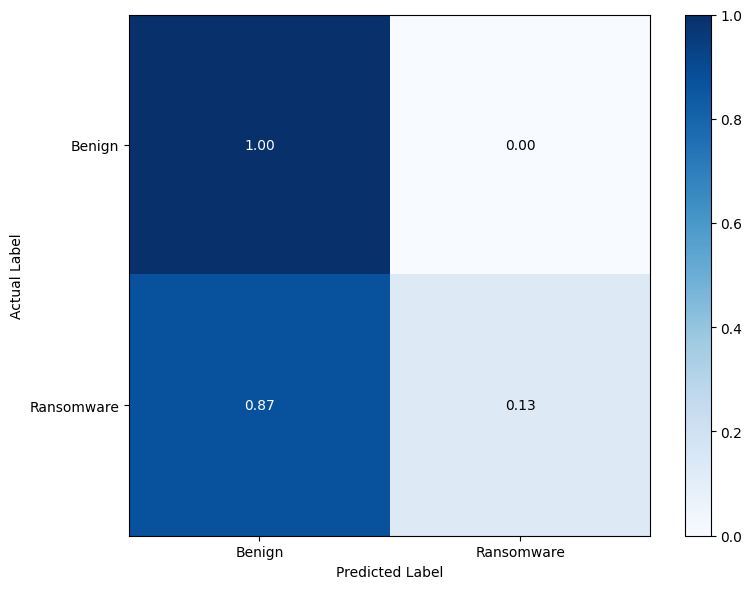

In [249]:
confusionMatrix_vit_gaf_aug = confusion_matrix(y_test_int, vit_gaf_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_gaf_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_gaf_aug.shape[0]):
    for j in range(confusionMatrix_vit_gaf_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_gaf_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_gaf_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()